<h2> Final File </h2>
<p>In this file we will load the unet models for lung mask, infection mask and vgg16 model for detect if the ct scan is covid positive or not. We will test 10 covid images and 10 Non-Covid images that are not from the dataset we have trained the model from and test its intra - dataset accuracy </p>
<br>
<p> images are taken from kaggle </p>
<br>
<p> First we segment the lung from the ct-scan (unet model) ------> Send the segmented lung into vgg model -------> If covid +ve shows the ctscans with its infection location else it just shows the final ctscan </p>

In [50]:
import os
import cv2
import keras
import numpy as np
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from keras.models import load_model  
#from keras.utils import plot_model
from keras import Sequential
from keras.layers import Conv2D,MaxPooling2D,Flatten,Softmax,Activation,Dense,Dropout
from keras.callbacks import Callback,ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,auc
#from skimage.transform import rescale, resize
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
import pickle
from skimage import measure
from skimage import morphology
from skimage.transform import resize
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import h5py
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras.models import load_model 
from keras.utils.vis_utils import plot_model
import cv2
import os
from sklearn.model_selection import train_test_split
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from learntools.core import binder
binder.bind(globals())
from learntools.computer_vision.ex2 import *
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB1
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.densenet  import DenseNet169
from keras.layers import LSTM
from keras.layers import TimeDistributed
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from learntools.core import binder
binder.bind(globals())
from learntools.computer_vision.ex2 import *
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB1
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.densenet  import DenseNet169
from keras.layers import LSTM
from keras.layers import TimeDistributed

In [3]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(tf.multiply(y_true_f, y_pred_f))
    score = (2. * intersection) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    union = K.sum(y_true, [1, 2, 3])+K.sum(y_pred, [1, 2, 3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def recall(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    y_true_f = tf.round(y_true_f)
    y_pred_f = tf.round(y_pred_f)
    intersection = tf.reduce_sum(tf.multiply(y_true_f, y_pred_f))
    re = intersection/(tf.reduce_sum(y_true_f)+1)
    return re

def precision(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    y_true_f = tf.round(y_true_f)
    y_pred_f = tf.round(y_pred_f)
    intersection = tf.reduce_sum(tf.multiply(y_true_f, y_pred_f))
    pr = intersection/(tf.reduce_sum(y_pred_f)+1)
    return pr

In [25]:
def get_lung_mask(filename,model):
    img = cv2.imread(filename)
    i2 = cv2.imread(filename)
    image = cv2.imread(filename)
    image = cv2.resize(image,(128,128))
    image = image.reshape(128,128,3)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img,(128,128))
    img = img.reshape(128,128,1)
    min_val = img.min()
    max_val = img.max()
    img = (img - min_val) / (max_val - min_val)*255
    img2 = img[np.newaxis, :, :, :]
    print(img.shape)
    pmask = model.predict(img2)
    pmask = np.squeeze(pmask)
    pmask[pmask!=0] = 255
    #img[pmask != 255] = 0
    image[pmask==0] = (0,0,0)
    image = cv2.resize(image,(224,224))
    image = image.reshape(224,224,3)
    non_black_pixels = np.any(image != [0, 0, 0], axis=-1).nonzero()
    bbox = (
        np.min(non_black_pixels[1]),  # Left
        np.min(non_black_pixels[0]),  # Top
        np.max(non_black_pixels[1]),  # Right
        np.max(non_black_pixels[0]),  # Bottom
    )
    cropped_img = Image.fromarray(image).crop(bbox)
    cropped_img = np.array(cropped_img)
    cropped_img = cv2.resize(cropped_img,(224,224))
    cropped_img = cropped_img.reshape(224,224,3)
    return pmask,cropped_img

In [9]:
def get_infection_mask(filename,model):
    img = cv2.imread(filename)
    i2 = cv2.imread(filename)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img,(128,128))
    img = img.reshape(128,128,1)
    min_val = img.min()
    max_val = img.max()
    img = (img - min_val) / (max_val - min_val)*255
    img2 = img[np.newaxis, :, :, :]
    print(img.shape)
    pmask = model.predict(img2)
    pmask = np.squeeze(pmask)
    return i2,img,pmask

<h2> Load the model </h2>

In [48]:
lung_mask_model = load_model(r'h5 files\lung_mask_unet.h5', custom_objects={"dice_coeff": dice_coeff,"iou_coef": iou_coef,"recall": recall,"precision":precision })
infection_mask_model = load_model(r'h5 files\infection_mask_unet.h5', custom_objects={"dice_coeff": dice_coeff,"iou_coef": iou_coef,"recall": recall,"precision":precision })
vggmodel = load_model(r'h5 files\vggmodel(version1)_new.weights.best.hdf5')

<h2> Covid Images </h2>

(128, 128, 1)
1/1 [==============================] - 0s 222ms/step
(128, 128, 1)
1/1 [==============================] - 0s 269ms/step


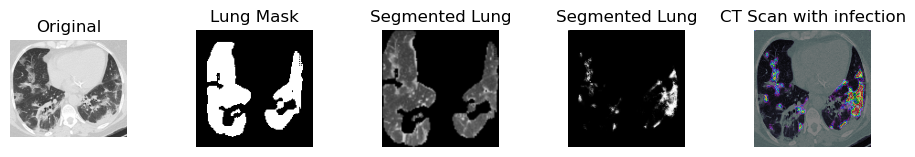

(128, 128, 1)
1/1 [==============================] - 0s 22ms/step
(128, 128, 1)
1/1 [==============================] - 0s 22ms/step


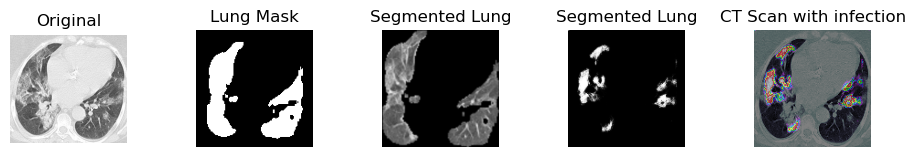

(128, 128, 1)
1/1 [==============================] - 0s 21ms/step
(128, 128, 1)
1/1 [==============================] - 0s 22ms/step


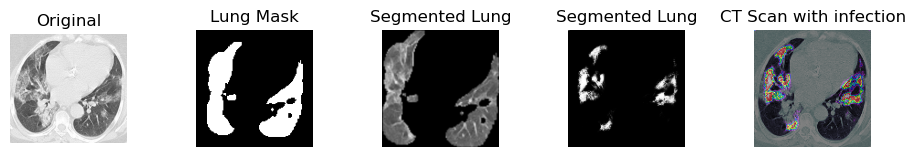

(128, 128, 1)
1/1 [==============================] - 0s 21ms/step
(128, 128, 1)
1/1 [==============================] - 0s 21ms/step


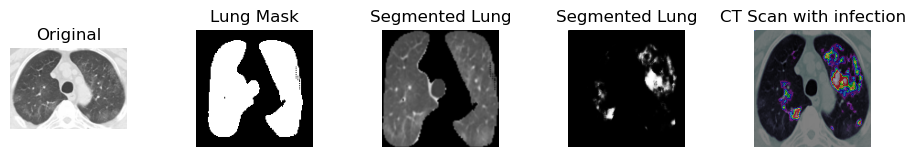

(128, 128, 1)
1/1 [==============================] - 0s 22ms/step
(128, 128, 1)
1/1 [==============================] - 0s 21ms/step


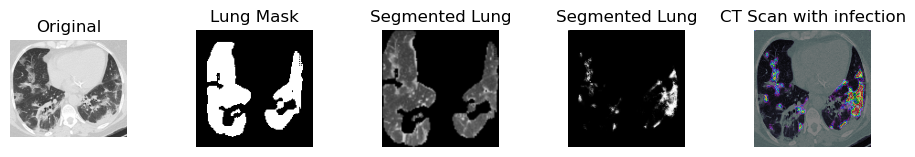

In [49]:
filenames = ['/kaggle/input/sarscov2-ctscan-dataset/COVID/Covid (10).png','/kaggle/input/sarscov2-ctscan-dataset/COVID/Covid (1001).png','/kaggle/input/sarscov2-ctscan-dataset/COVID/Covid (1010).png','/kaggle/input/sarscov2-ctscan-dataset/COVID/Covid (1101).png','/kaggle/input/sarscov2-ctscan-dataset/COVID/Covid (10).png']
for filename in filenames:
    img = cv2.imread(filename)
    mask,lung = get_lung_mask(filename,lung_mask_model)
    lung2 = lung[np.newaxis, :, :, :]
    prediction = vggmodel.predict(lung2)
    prediction = np.argmax(prediction, axis=1)
    prediction = prediction[0]
    if prediction == 0:
        original,image,infec =  get_infection_mask(filename,infection_mask_model)
        fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(10, 5))
        ax[0].imshow(img)
        ax[0].set_title("Original", fontsize=12)
        ax[0].axis('off')

        ax[1].imshow(mask,cmap='gray')
        ax[1].set_title("Lung Mask", fontsize=12)
        ax[1].axis('off')

        ax[2].imshow(lung)
        ax[2].set_title("Segmented Lung", fontsize=12)
        ax[2].axis('off')

        ax[3].imshow(infec,cmap='gray')
        ax[3].set_title("Segmented Lung", fontsize=12)
        ax[3].axis('off')

        ax[4].imshow(image,cmap='bone')
        ax[4].imshow(infec,alpha = 0.5, cmap = "nipy_spectral")
        ax[4].set_title("CT Scan with infection", fontsize=12)
        ax[4].axis('off')
        fig.tight_layout(pad=5.0)
        plt.show()
    else:
        original,image,infec =  get_infection_mask(filename,infection_mask_model)
        fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 5))
        ax[0].imshow(img)
        ax[0].set_title("Original", fontsize=12)
        ax[0].axis('off')

        ax[1].imshow(mask,cmap='gray')
        ax[1].set_title("Lung Mask", fontsize=12)
        ax[1].axis('off')

        ax[2].imshow(lung)
        ax[2].set_title("Segmented Lung", fontsize=12)
        ax[2].axis('off')

        ax[3].imshow(image,cmap='bone')
        ax[3].set_title("Final CT Scan", fontsize=12)
        ax[3].axis('off')
        fig.tight_layout(pad=5.0)
        plt.show()

<h3> Non-Covid </h3>

(128, 128, 1)
1/1 [==============================] - 0s 19ms/step
(128, 128, 1)
1/1 [==============================] - 0s 19ms/step


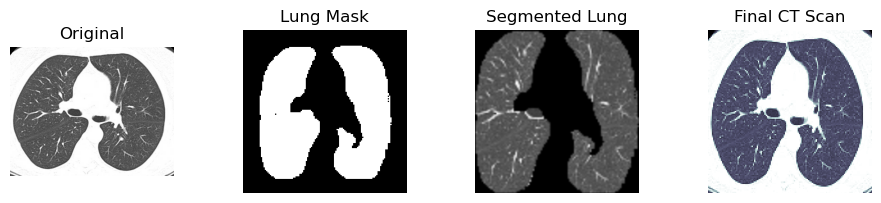

(128, 128, 1)
1/1 [==============================] - 0s 19ms/step
(128, 128, 1)
1/1 [==============================] - 0s 18ms/step


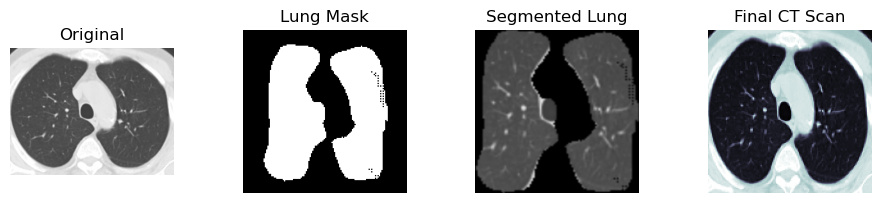

(128, 128, 1)
1/1 [==============================] - 0s 19ms/step
(128, 128, 1)
1/1 [==============================] - 0s 19ms/step


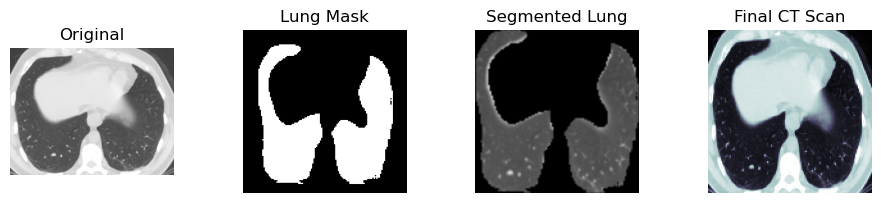

(128, 128, 1)
1/1 [==============================] - 0s 24ms/step
(128, 128, 1)
1/1 [==============================] - 0s 25ms/step


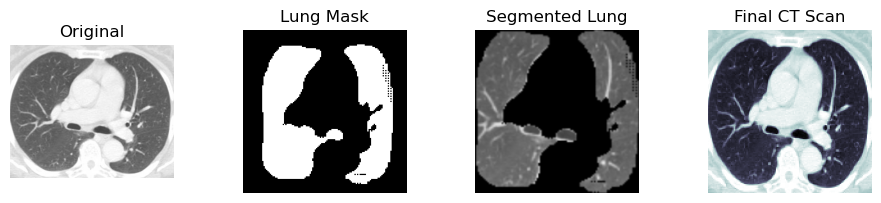

(128, 128, 1)
1/1 [==============================] - 0s 24ms/step
(128, 128, 1)
1/1 [==============================] - 0s 24ms/step


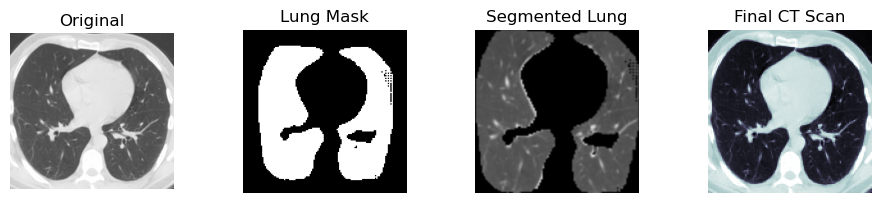

(128, 128, 1)
1/1 [==============================] - 0s 25ms/step
(128, 128, 1)
1/1 [==============================] - 0s 25ms/step


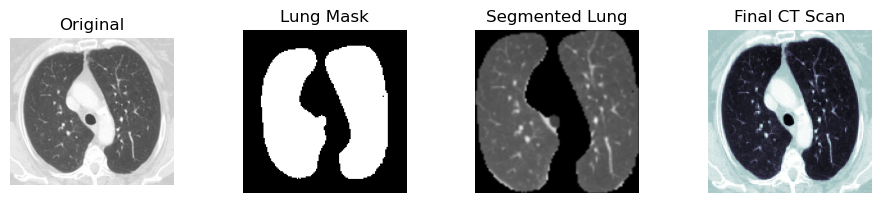

In [46]:
filenames = ['/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (1119).png','/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (548).png','/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (634).png','/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (875).png','/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (636).png','/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (528).png']
for filename in filenames:
    img = cv2.imread(filename)
    mask,lung = get_lung_mask(filename,lung_mask_model)
    lung2 = lung[np.newaxis, :, :, :]
    prediction = vggmodel.predict(lung2)
    prediction = np.argmax(prediction, axis=1)
    prediction = prediction[0]
    if prediction == 0:
        original,image,infec =  get_infection_mask(filename,infection_mask_model)
        fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(10, 5))
        ax[0].imshow(img)
        ax[0].set_title("Original", fontsize=12)
        ax[0].axis('off')

        ax[1].imshow(mask,cmap='gray')
        ax[1].set_title("Lung Mask", fontsize=12)
        ax[1].axis('off')

        ax[2].imshow(lung)
        ax[2].set_title("Segmented Lung", fontsize=12)
        ax[2].axis('off')

        ax[3].imshow(infec,cmap='gray')
        ax[3].set_title("Segmented Lung", fontsize=12)
        ax[3].axis('off')

        ax[4].imshow(image,cmap='bone')
        ax[4].imshow(infec,alpha = 0.5, cmap = "nipy_spectral")
        ax[4].set_title("CT Scan with infection", fontsize=12)
        ax[4].axis('off')
        fig.tight_layout(pad=5.0)
        plt.show()
    else:
        original,image,infec =  get_infection_mask(filename,infection_mask_model)
        fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 5))
        ax[0].imshow(img)
        ax[0].set_title("Original", fontsize=12)
        ax[0].axis('off')

        ax[1].imshow(mask,cmap='gray')
        ax[1].set_title("Lung Mask", fontsize=12)
        ax[1].axis('off')

        ax[2].imshow(lung)
        ax[2].set_title("Segmented Lung", fontsize=12)
        ax[2].axis('off')

        ax[3].imshow(image,cmap='bone')
        ax[3].set_title("Final CT Scan", fontsize=12)
        ax[3].axis('off')
        fig.tight_layout(pad=5.0)
        plt.show()